<a href="https://colab.research.google.com/github/ptleskin/GraphAlgorithmImplementation/blob/master/LetterSampo_Mathematicians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations and Imports

In [ ]:
!pip install SPARQLWrapper numpy sklearn matplotlib pandas rdflib

     |████████████████████████████████| 482 kB 11.3 MB/s 
     |████████████████████████████████| 41 kB 720 kB/s 


In [ ]:
from SPARQLWrapper import SPARQLWrapper, JSON
from collections import Counter, defaultdict
from datetime import datetime
from math import radians, degrees, cos, sin, asin, sqrt, atan2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from scipy.signal import convolve2d
from sklearn.preprocessing import MultiLabelBinarizer, minmax_scale

import seaborn as sns

from collections import Counter, OrderedDict, defaultdict
from itertools import product, combinations
from rdflib.namespace import XSD, Namespace
from rdflib import URIRef

from scipy.stats import binned_statistic
from scipy.optimize import curve_fit

from scipy.interpolate import Akima1DInterpolator, CubicHermiteSpline

import IPython

# Functions

In [ ]:
def checkDate(v):
  try:
    d = datetime.strptime(v, '%Y-%m-%dT%H:%M:%S').date()
  except ValueError:
    m = re.match(r'(\d{4})-(\d{2})-(\d{2})', v)
    d = datetime(int(m.groups()[0]), int(m.groups()[1]), 28).date()
  return d

DATATYPECONVERTERS = {
      str(XSD.integer):  int,
      str(XSD.decimal):  float,
      str(XSD.date):     lambda v: datetime.strptime(v, '%Y-%m-%d').date(),
      str(XSD.dateTime): checkDate
  }

def convertDatatype(obj):
  return DATATYPECONVERTERS.get(obj.get('datatype'), str)(obj.get('value')) 

def convertDatatypes(results):
    res = results["results"]["bindings"]
    return [dict([(k, convertDatatype(v)) for k,v in r.items()]) for r in res]

def JSON2Pandas(results):
    return pd.DataFrame(convertDatatypes(results))

def getIntervalStart(iv):
  try:
    return int(iv.left)
  except AttributeError:
    return None

def getIntervalRange(iv):
  try:
    return "{}-{}".format(int(iv.left), int(iv.right)) 
  except AttributeError:
    return None

def getAkimaSpline(X, Y, n=10):
  # n*(len(X)-1)+1 makes original data points to appear in the linspace
  spl = Akima1DInterpolator(X, Y)

  X2 = np.linspace(min(X), max(X), n*(len(X)-1)+1) 
  return X2, spl(X2)


def getSpline(X, Y, n=10):
  # n*(len(X)-1)+1 makes original data points to appear in the linspace
  spl = CubicHermiteSpline(X,Y, [0 for _ in X])
  
  X2 = np.linspace(min(X), max(X), n*(len(X)-1)+1) 
  return X2, spl(X2)

def drawHeatmapMatrix(M, labels, xlabels, ylabels, 
                      contrast=1/200, 
                      format='.2f', 
                      cmap = "Blues",
                      normalize = 'rows'):
  M2 = convolve2d(M, np.array([[-1,-3,-1],[-3,17,-3],[-1,-3,-1]]), mode = 'same', boundary="symm")
  
  if normalize == 'all':
    # scale to actual range
    hi=np.max(M)
    lo=np.min(M)
    M2 = M2*contrast+M 
    M2 = (M2-np.min(M2))/(np.max(M2)-np.min(M2))*(hi-lo)+lo
  elif normalize == 'columns':
    M2 = minmax_scale(M2*contrast+M, feature_range=(np.min(M), np.max(M)), axis=0)
  else:
  # scaling by columns or rows:
    M2 = minmax_scale(M2*contrast+M, feature_range=(np.min(M), np.max(M)), axis=1)

  sns.heatmap(M2,
              annot = labels,
              center = 0.1, 
              fmt = format,
              square = True, 
              linewidths = 2, 
              robust = True,
              xticklabels = xlabels,
              yticklabels = ylabels,
              cmap = cmap,
              cbar = False
              )

In [ ]:
from scipy.interpolate import CubicHermiteSpline

def getSpline(X, Y, n=10):
  # n*(len(X)-1)+1 makes original data points to appear in the linspace
  X2 = np.linspace(min(X), max(X), n*(len(X)-1)+1) 
  spl = CubicHermiteSpline(X,Y, [0 for _ in X])
  return X2, spl(X2)

def simplifyLabel(st):
  st = re.sub(r'[,0-9 -]+$', '', st)
  st = re.sub(r' \([^)]+\)', '', st)
  return st

## Using JavaScript library ApexCharts inside a Google Colab

In [ ]:
def getLineChartHTML(series,
                     title_text="",
                     xaxis={},
                     yaxis={},
                     chart_height=350):
  return '''
    <div id="container"></div>
    <script src="https://cdn.jsdelivr.net/npm/apexcharts"></script>
    <script language="javascript">
      var options = {
        series: '''+str(series)+''' ,
        chart: { height: '''+str(chart_height)+''', type: 'line' },
        dataLabels: { enabled: false },
        stroke: { curve: 'smooth', width: 2 },
        title: { text: "'''+title_text+'''", align: 'left' },
        grid: {
          row: {
            colors: ['#f3f3f3', 'transparent'], 
            opacity: 0.5
          },
        },
        xaxis: '''+str(xaxis)+''',
        yaxis: '''+str(yaxis)+'''
        };
      var chart = new ApexCharts(document.querySelector("#container"), options);
      chart.render();
    </script> '''

# Query the Data 
try it in Yasgui: https://api.triplydb.com/s/6hhVwafz2


In [ ]:
sparql = SPARQLWrapper("http://ldf.fi/ckcc/sparql")
sparql.setQuery("""
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX lsscs: <http://ldf.fi/schema/lssc/>

SELECT DISTINCT 
  ?sender__id ?sender__label ?sender__title
  ?receiver__id ?receiver__label ?receiver__title
  ?from_id ?from ?from_country
  ?to_id ?to ?to_country
  ?start ?end
WHERE {
    ?id a lsscs:Letter ;
    	^lsscs:created ?sender__id ;
    	lsscs:was_addressed_to ?receiver__id ;
    	crm:P4_has_time-span [ 
      		crm:P82a_begin_of_the_begin ?start ; 
        	crm:P82b_end_of_the_end ?end ] .
  
    ?sender__id skos:prefLabel ?sender__label ; skos:altLabel ?sender__title .
    ?receiver__id skos:prefLabel ?receiver__label ; skos:altLabel ?receiver__title .

    FILTER (REGEX(STR(?sender__title), "physician|mathematician|chemist|Descartes", "i") &&
      REGEX(STR(?receiver__title), "physician|mathematician|chemist|Descartes", "i"))

    OPTIONAL {
      ?id lsscs:was_sent_from ?from_id .
      OPTIONAL {
        ?from_id skos:prefLabel ?from .
        OPTIONAL { ?from_id crm:P89_falls_within* [ 
            	a lsscs:Country ;
            	skos:prefLabel ?from_country 
        	]
        }
      }
    }
  
    OPTIONAL {
      ?id lsscs:was_sent_to ?to_id .
      OPTIONAL {
        ?to_id skos:prefLabel ?to .
        OPTIONAL { ?to_id crm:P89_falls_within* [ 
            	a lsscs:Country ;
                skos:prefLabel ?to_country 
        	]
        }
      }
    }
} """)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

vars = results['head']['vars']
print("Query returned {} results".format(len(results["results"]["bindings"])))

for ob in results["results"]["bindings"][:10]:
  print(ob)

Query returned 1297 results
{'sender__id': {'type': 'uri', 'value': 'http://ldf.fi/ckcc/actors/p11763'}, 'sender__label': {'type': 'literal', 'value': 'Huygens, Christiaan, 1629-1695'}, 'sender__title': {'type': 'literal', 'value': 'Dutch physicist, mathematician, and astonomer'}, 'receiver__id': {'type': 'uri', 'value': 'http://ldf.fi/ckcc/actors/p600017'}, 'receiver__label': {'type': 'literal', 'value': 'Schooten, Frans van, 1615-1660'}, 'receiver__title': {'type': 'literal', 'value': 'Dutch mathematician'}, 'from_id': {'type': 'uri', 'value': 'http://ldf.fi/ckcc/places/p1639'}, 'from': {'type': 'literal', 'value': 'The Hague'}, 'from_country': {'type': 'literal', 'value': 'Netherlands'}, 'to_id': {'type': 'uri', 'value': 'http://ldf.fi/ckcc/places/p900077'}, 'to': {'type': 'literal', 'value': 'Leiden'}, 'to_country': {'type': 'literal', 'value': 'Netherlands'}, 'start': {'type': 'literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'value': '1658-10-01T00:00:00'}, 'end

## Show the query results as a Pandas Dataframe

In [ ]:
df = JSON2Pandas(results)

df.sender__label = df.apply(lambda x: simplifyLabel(x.sender__label), axis = 1)
df.receiver__label = df.apply(lambda x: simplifyLabel(x.receiver__label), axis = 1)

df['start_year'] = df.apply(lambda x: x.start.year, axis=1)
df['end_year'] = df.apply(lambda x: x.end.year, axis=1)

display(df)

,sender__id,sender__label,sender__title,receiver__id,receiver__label,receiver__title,from_id,from,from_country,to_id,to,to_country,start,end,start_year,end_year
0,http://ldf.fi/ckcc/actors/p11763,"Huygens, Christiaan","Dutch physicist, mathematician, and astonomer",http://ldf.fi/ckcc/actors/p600017,"Schooten, Frans van",Dutch mathematician,http://ldf.fi/ckcc/places/p1639,The Hague,Netherlands,http://ldf.fi/ckcc/places/p900077,Leiden,Netherlands,1658-10-01,1658-10-31,1658,1658
1,http://ldf.fi/ckcc/actors/p11763,"Huygens, Christiaan","Dutch physicist, mathematician, and astonomer",http://ldf.fi/ckcc/actors/p900430,"Boulliau, Ismaël","French theologian, mathematician, astronomer",http://ldf.fi/ckcc/places/p1639,The Hague,Netherlands,http://ldf.fi/ckcc/places/p300017,Paris,France,1658-10-01,1658-10-31,1658,1658
2,http://ldf.fi/ckcc/actors/p11763,"Huygens, Christiaan","Dutch physicist, mathematician, and astonomer",http://ldf.fi/ckcc/actors/p906146,"Petit, Pierre, 1598 or before",mathematician,http://ldf.fi/ckcc/places/p1639,The Hague,Netherlands,http://ldf.fi/ckcc/places/p300017,Paris,France,1658-11-01,1658-11-01,1658,1658
3,http://ldf.fi/ckcc/actors/p11763,"Huygens, Christiaan","Dutch physicist, mathematician, and astonomer",http://ldf.fi/ckcc/actors/p900430,"Boulliau, Ismaël","French theologian, mathematician, astronomer",http://ldf.fi/ckcc/places/p1639,The Hague,Netherlands,http://ldf.fi/ckcc/places/p300017,Paris,France,1658-11-21,1658-11-21,1658,1658
4,http://ldf.fi/ckcc/actors/p11763,"Huygens, Christiaan","Dutch physicist, mathematician, and astonomer",http://ldf.fi/ckcc/actors/p900430,"Boulliau, Ismaël","French theologian, mathematician, astronomer",http://ldf.fi/ckcc/places/p1639,The Hague,Netherlands,http://ldf.fi/ckcc/places/p300017,Paris,France,1659-01-09,1659-01-09,1659,1659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,http://ldf.fi/ckcc/actors/p903715,"Regius, Henricus",Dutch philosopher and physician,http://ldf.fi/ckcc/actors/p300075,"Descartes, René","Cartesius; Rene Descartes; Cartesius, Renatus",http://ldf.fi/ckcc/places/p59,Utrecht,Netherlands,http://ldf.fi/ckcc/places/p300041,Egmond-Binnen,Netherlands,1645-07-06,1645-07-06,1645,1645
1293,http://ldf.fi/ckcc/actors/p903715,"Regius, Henricus",Dutch philosopher and physician,http://ldf.fi/ckcc/actors/p300075,"Descartes, René","Cartesius; Rene Descartes; Cartesius, Renatus",http://ldf.fi/ckcc/places/p59,Utrecht,Netherlands,http://ldf.fi/ckcc/places/p300041,Egmond-Binnen,Netherlands,1645-07-23,1645-07-23,1645,1645
1294,http://ldf.fi/ckcc/actors/p903723,"Villebressieu, Étienne de, fl.",French chemist and natural philosopher,http://ldf.fi/ckcc/actors/p300075,"Descartes, René","Cartesius; Rene Descartes; Cartesius, Renatus",NaN,NaN,NaN,http://ldf.fi/ckcc/places/p300024,Amsterdam,Netherlands,1631-05-01,1631-05-31,1631,1631
1295,http://ldf.fi/ckcc/actors/p905112,"Dam, Albert Jansz. van","Dutch cartographer, surveyor, mathematician an...",http://ldf.fi/ckcc/actors/p905129,"Voogt, Klaas Jansz, d.",Mathematician in Monnikendam and Amsterdam,http://ldf.fi/ckcc/places/p900660,Hoorn,Netherlands,NaN,NaN,NaN,1677-06-29,1677-06-29,1677,1677


## Timeline of Letters

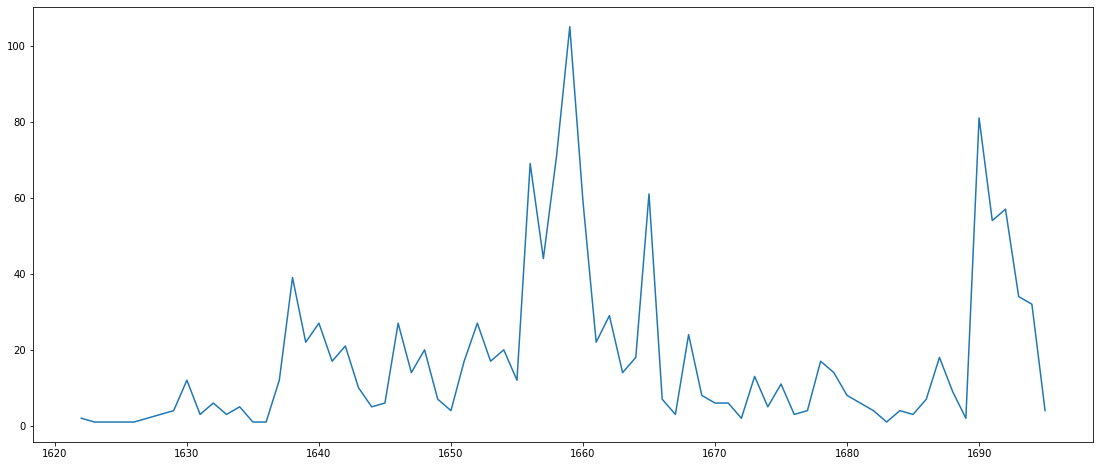

In [ ]:
cn_years = Counter()
cn_years.update(df.start_year)
X = sorted(cn_years.keys())
Y = [cn_years[x] for x in X]

fig = plt.figure(figsize=[19.0, 8.0])
ax = fig.add_subplot()
ax.plot(X,Y)

plt.show()

## Most active actors in the data defined by the number of sent or received letters

In [ ]:
def emphasize(val):
    rx = re.compile(r'^(.+) ([()0-9]+)$')
    st = rx.sub(r'\1', val)

    cnd = cn_actors_sent.get(st, 0) > cn_actors_received.get(st, 0)
    style = 'normal' if cnd else 'italic'
    color = 'blue' if cnd else 'black'
    return "font-style: {}; color: {}".format(style, color)

cn_actors_sent = Counter(df.sender__label)
cn_actors_received = Counter(df.receiver__label)
cn_actors = cn_actors_sent + cn_actors_received

lookup_actors = OrderedDict([(k,i) for i,(k,_) in enumerate(cn_actors.most_common(50))])

N = 12
df_top = pd.DataFrame()
df_top['Sender'] = ["{} ({})".format(k,v) for k,v in cn_actors_sent.most_common(N)]
df_top['Receiver'] = ["{} ({})".format(k,v) for k,v in cn_actors_received.most_common(N)]
df_top['All'] = ["{} ({})".format(k,v) for k,v in cn_actors.most_common(N)]

df_top.index += 1
display(df_top)

,Sender,Receiver,All
1,"Huygens, Christiaan (418)","Huygens, Christiaan (589)","Huygens, Christiaan (1007)"
2,"Descartes, René (192)","Mersenne, Marin (135)","Descartes, René (239)"
3,"Leibniz, Gottfried Wilhelm (72)","Schooten, Frans van (65)","Mersenne, Marin (149)"
4,"Sluse, René François de (67)","Leibniz, Gottfried Wilhelm (60)","Leibniz, Gottfried Wilhelm (132)"
5,"Schooten, Frans van (57)","Descartes, René (47)","Schooten, Frans van (122)"
6,"Wallis, John (52)","Wallis, John (40)","Sluse, René François de (97)"
7,"Boulliau, Ismaël (46)","Boulliau, Ismaël (30)","Wallis, John (92)"
8,"Fatio de Duillier, Nicolas (37)","Sluse, René François de (30)","Boulliau, Ismaël (76)"
9,"Regius, Henricus (26)","Fatio de Duillier, Nicolas (30)","Fatio de Duillier, Nicolas (67)"
10,"Petit, Pierre, 1598 or before (24)","Carcavi, Pierre de (26)","Carcavi, Pierre de (41)"


## Emphasizing those actors who have sent more letters than received

In [ ]:
df_occ2 = df_top.style.applymap(emphasize)
display(df_occ2)

,Sender,Receiver,All
1,"Huygens, Christiaan (418)","Huygens, Christiaan (589)","Huygens, Christiaan (1007)"
2,"Descartes, René (192)","Mersenne, Marin (135)","Descartes, René (239)"
3,"Leibniz, Gottfried Wilhelm (72)","Schooten, Frans van (65)","Mersenne, Marin (149)"
4,"Sluse, René François de (67)","Leibniz, Gottfried Wilhelm (60)","Leibniz, Gottfried Wilhelm (132)"
5,"Schooten, Frans van (57)","Descartes, René (47)","Schooten, Frans van (122)"
6,"Wallis, John (52)","Wallis, John (40)","Sluse, René François de (97)"
7,"Boulliau, Ismaël (46)","Boulliau, Ismaël (30)","Wallis, John (92)"
8,"Fatio de Duillier, Nicolas (37)","Sluse, René François de (30)","Boulliau, Ismaël (76)"
9,"Regius, Henricus (26)","Fatio de Duillier, Nicolas (30)","Fatio de Duillier, Nicolas (67)"
10,"Petit, Pierre, 1598 or before (24)","Carcavi, Pierre de (26)","Carcavi, Pierre de (41)"


## Most active actors by decades of activity

In [ ]:
N = 10
top_no = 6
df['bin'] = pd.cut(df['start_year'], range(1600, 1800, N))
df['bin'] = df.apply(lambda x: getIntervalRange(x.bin), axis=1)

XY = defaultdict(lambda: Counter())
actors_top = set()

for col in ['sender__label','receiver__label']:#['sender__label']:
  for (label, bin), val in df.groupby([col, 'bin']).size().iteritems():
    if val>0:
      XY[bin][label] += val

df_ranks = pd.DataFrame()

for bin in sorted(XY.keys()):
  cnt = XY[bin]
  df_ranks[bin] = ["{} ({})".format(simplifyLabel(k),v) for k,v in (cnt.most_common()+[('', 0)]*top_no)[:top_no]]
  for k,_ in cnt.most_common(2):
    actors_top.update([k])

display(df_ranks)

,1620-1630,1630-1640,1640-1650,1650-1660,1660-1670,1670-1680,1680-1690,1690-1700
0,"Descartes, René (21)","Descartes, René (115)","Descartes, René (103)","Huygens, Christiaan (425)","Huygens, Christiaan (166)","Huygens, Christiaan (80)","Huygens, Christiaan (129)","Huygens, Christiaan (181)"
1,"Mersenne, Marin (16)","Mersenne, Marin (69)","Mersenne, Marin (64)","Schooten, Frans van (112)","Sluse, René François de (32)","Leibniz, Gottfried Wilhelm (19)","Leibniz, Gottfried Wilhelm (30)","Leibniz, Gottfried Wilhelm (83)"
2,"Descartes, Pierre (3)","Regius, Henricus (13)","Huygens, Christiaan (26)","Boulliau, Ismaël (68)","Auzout, Adrien (21)","Grew, Nehemiah (9)","Fatio de Duillier, Nicolas (28)","Fatio de Duillier, Nicolas (39)"
3,"Descartes, Joachim (2)","Plempius, Vopiscus Fortunatus (8)","Regius, Henricus (23)","Sluse, René François de (64)","Petit, Pierre, 1598 or before (21)","Wallis, John (9)","Hire, Philippe de la (19)","L'Hôpital, Guillaume François Antoine de (30)"
4,(0),"Beaune, Florimond de (6)","Schooten, Frans van (9)","Wallis, John (63)","Wallis, John (20)","Hartsoeker, Nicolaas (7)","Graaf, Jan (13)","Steigerthal, Johann Georg (8)"
5,(0),"Morin, Jean-Baptiste (6)","Cavendish, Charles (8)","Saint-Vincent, Grégoire de (34)","Brouncker, William (17)","Brouncker, William (6)","Hudde, Johannes (8)","Graaf, Abraham (6)"


In [ ]:
actors_top = [k for k,_ in cn_actors.most_common(20)]

# actors20 = list(lookup_actors.keys())

# rankdata([0, 2, 113, 11], method='ordinal')
XY_people = defaultdict(lambda: defaultdict(int))
for bin, arr in XY.items():
  bin_int = int(re.sub(r'^(\d+)\D(.*)$', r'\1', bin))
  print(bin_int, [(k,i) for i,(k,v) in enumerate(arr.most_common(3))])
  for i, (label, count) in enumerate(arr.most_common(), start=1):
    if label in actors_top:
      XY_people[label][bin_int] = i

XY_people = dict([(k,v) for k,v in XY_people.items() if len(v)>1])

1640 [('Descartes, René', 0), ('Mersenne, Marin', 1), ('Huygens, Christiaan', 2)]
1660 [('Huygens, Christiaan', 0), ('Sluse, René François de', 1), ('Auzout, Adrien', 2)]
1670 [('Huygens, Christiaan', 0), ('Leibniz, Gottfried Wilhelm', 1), ('Grew, Nehemiah', 2)]
1650 [('Huygens, Christiaan', 0), ('Schooten, Frans van', 1), ('Boulliau, Ismaël', 2)]
1630 [('Descartes, René', 0), ('Mersenne, Marin', 1), ('Regius, Henricus', 2)]
1680 [('Huygens, Christiaan', 0), ('Leibniz, Gottfried Wilhelm', 1), ('Fatio de Duillier, Nicolas', 2)]
1620 [('Descartes, René', 0), ('Mersenne, Marin', 1), ('Descartes, Pierre', 2)]
1690 [('Huygens, Christiaan', 0), ('Leibniz, Gottfried Wilhelm', 1), ('Fatio de Duillier, Nicolas', 2)]


In [ ]:
cn_actors.most_common(12)
actors_top

['Huygens, Christiaan',
 'Descartes, René',
 'Mersenne, Marin',
 'Leibniz, Gottfried Wilhelm',
 'Schooten, Frans van',
 'Sluse, René François de',
 'Wallis, John',
 'Boulliau, Ismaël',
 'Fatio de Duillier, Nicolas',
 'Carcavi, Pierre de',
 'Saint-Vincent, Grégoire de',
 "L'Hôpital, Guillaume François Antoine de",
 'Regius, Henricus',
 'Petit, Pierre, 1598 or before',
 'Hudde, Johannes',
 'Hire, Philippe de la',
 'Brouncker, William',
 'Auzout, Adrien',
 'Graaf, Jan',
 'Tacquet, André']

In [ ]:
series=[]
xlabels = set()
keys = sorted(list(set().union(*[set(k.keys()) for k in XY_people.values()])))

for label in list(actors_top):
  arr = XY_people.get(label)
  if arr and len(arr)>1:
    X = keys # sorted(arr.keys())
    Y = [arr.get(x,'null') for x in keys]
    #series.append(dict(name=label, data=str([[x, y] for x,y in zip(X,Y)])))
    series.append('{'+'data: {}, name: "{}"'.format([[x, y] for x,y in zip(X,Y)], simplifyLabel(label)).replace("'","")+ "}")
    xlabels.update([str(x) for x in X])
xlabels = sorted(list(xlabels))
series = str(series).replace("'", "")
xlabels

['1620', '1630', '1640', '1650', '1660', '1670', '1680', '1690']

In [ ]:
html_code = getLineChartHTML(series,
                             chart_height = 450,
                             title_text = "Ranking",
                             yaxis = " {min: 0, max: 10, reversed: true }",
                             xaxis = " { categories: "+str(xlabels) +
                                     ", type: 'numeric'," +
                             " labels: { formatter: function (value) { return 10*Math.floor(value/10); } } }")

## The most active mathematicians in 1600–1700

In [ ]:
display(IPython.display.HTML(html_code))

# Query the Place Data

In [ ]:
sparql = SPARQLWrapper("http://ldf.fi/ckcc/sparql")
sparql.setQuery("""
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX lsscs: <http://ldf.fi/schema/lssc/>

SELECT DISTINCT ?sender ?receiver
	?from_id ?from ?from_country
	?to_id ?to ?to_country
	?start ?end
WHERE {
	?id a lsscs:Letter ;
  		# ^eschema:cofk_union_relationship_type-created/skos:prefLabel ?sender ;
			# eschema:cofk_union_relationship_type-was_addressed_to/skos:prefLabel ?receiver ;
    	lsscs:was_sent_from ?from_id ;
	    lsscs:was_sent_to ?to_id ;
      crm:P4_has_time-span [ crm:P82a_begin_of_the_begin ?start ; crm:P82b_end_of_the_end ?end ] .
                                                                                        
	?from_id skos:prefLabel ?from .
	#	FILTER (?from not in ("Zürich"))
	OPTIONAL { ?from_id crm:P89_falls_within* [ a lsscs:Country ;
										skos:prefLabel ?from_country ]
	}
  
	?to_id skos:prefLabel ?to .
	#	FILTER (?to not in ("Zürich"))
	OPTIONAL { ?to_id crm:P89_falls_within* [ a lsscs:Country ;
										skos:prefLabel ?to_country ]
	}
} """)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

vars = results['head']['vars']
print("{} results".format(len(results["results"]["bindings"])))

for ob in results["results"]["bindings"][:10]:
  print(ob)

df = JSON2Pandas(results)
df['start_year'] = df.apply(lambda x: x.start.year, axis=1)
display(df)


20416 results
{'from_id': {'type': 'uri', 'value': 'http://ldf.fi/ckcc/places/p900077'}, 'from': {'type': 'literal', 'value': 'Leiden'}, 'from_country': {'type': 'literal', 'value': 'Netherlands'}, 'to_id': {'type': 'uri', 'value': 'http://ldf.fi/ckcc/places/p1639'}, 'to': {'type': 'literal', 'value': 'The Hague'}, 'to_country': {'type': 'literal', 'value': 'Netherlands'}, 'start': {'type': 'literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'value': '1625-04-31T00:00:00'}, 'end': {'type': 'literal', 'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime', 'value': '1625-04-31T23:59:59'}}
{'from_id': {'type': 'uri', 'value': 'http://ldf.fi/ckcc/places/p900077'}, 'from': {'type': 'literal', 'value': 'Leiden'}, 'from_country': {'type': 'literal', 'value': 'Netherlands'}, 'to_id': {'type': 'uri', 'value': 'http://ldf.fi/ckcc/places/p900077'}, 'to': {'type': 'literal', 'value': 'Leiden'}, 'to_country': {'type': 'literal', 'value': 'Netherlands'}, 'start': {'type': 'literal'

,from_id,from,from_country,to_id,to,to_country,start,end,start_year
0,http://ldf.fi/ckcc/places/p900077,Leiden,Netherlands,http://ldf.fi/ckcc/places/p1639,The Hague,Netherlands,1625-04-28,1625-04-28,1625
1,http://ldf.fi/ckcc/places/p900077,Leiden,Netherlands,http://ldf.fi/ckcc/places/p900077,Leiden,Netherlands,1597-01-01,1597-12-31,1597
2,http://ldf.fi/ckcc/places/p900077,Leiden,Netherlands,http://ldf.fi/ckcc/places/p900077,Leiden,Netherlands,1597-06-28,1597-06-28,1597
3,http://ldf.fi/ckcc/places/p900077,Leiden,Netherlands,http://ldf.fi/ckcc/places/p900077,Leiden,Netherlands,1598-01-01,1598-12-31,1598
4,http://ldf.fi/ckcc/places/p901003,Dragsholm,Denmark,http://ldf.fi/ckcc/places/p900077,Leiden,Netherlands,1598-01-08,1598-01-08,1598
...,...,...,...,...,...,...,...,...,...
20411,http://ldf.fi/ckcc/places/p300217,Delft,Netherlands,http://ldf.fi/ckcc/places/p1606,London,United Kingdom,1707-07-05,1707-07-05,1707
20412,http://ldf.fi/ckcc/places/p300217,Delft,Netherlands,http://ldf.fi/ckcc/places/p1606,London,"England, United Kingdom",1707-07-05,1707-07-05,1707
20413,http://ldf.fi/ckcc/places/p300217,Delft,Netherlands,http://ldf.fi/ckcc/places/p1606,London,England,1707-07-12,1707-07-12,1707
20414,http://ldf.fi/ckcc/places/p300217,Delft,Netherlands,http://ldf.fi/ckcc/places/p1606,London,United Kingdom,1707-07-12,1707-07-12,1707


## Most referenced places

In [ ]:
N = 12

cn_places = Counter()
cn_places.update(df['from'].dropna())
cn_places.update(df.to.dropna())

lookup_places = OrderedDict([(k,i) for i,(k,_) in enumerate(cn_places.most_common(N))])

cn_places.most_common(20)

[('The Hague', 10686),
 ('Paris', 8195),
 ('London', 3558),
 ('Amsterdam', 1208),
 ('Leiden', 1170),
 ('Zürich', 758),
 ('Breda', 742),
 ('Delft', 731),
 ('Middelburg', 712),
 ('Stockholm', 660),
 ('Hamburg', 598),
 ('Rotterdam', 529),
 ('Orange', 455),
 ('Bergen op Zoom', 422),
 ('Brussels', 402),
 ('Assenede', 323),
 ('Ginneken', 310),
 ('Antwerp', 306),
 ('Utrecht', 303),
 ('Buren', 249)]

## Most referenced countries

In [ ]:
N = 15

cn_countries = Counter()
cn_countries.update(df.from_country.dropna())
cn_countries.update(df.to_country.dropna())

for s,t in [('Brussels, Brussels Capital Region, (Spanish Netherlands) Belgium', 'Belgium'),
            ('Poland, [Kingdom of Poland]', 'Poland'),
            ('England, United Kingdom', 'United Kingdom'),
            ('England', 'United Kingdom'),
            ('Scotland, United Kingdom', 'United Kingdom'),
            ('Scotland', 'United Kingdom'),
            ('Brussels', 'Belgium')
            ]:
      cn_countries[t] += cn_countries[s]
      del cn_countries[s]

lookup_countries = OrderedDict([(k,i) for i,(k,_) in enumerate(cn_countries.most_common(N))])

cn_countries.most_common(20)

[('Netherlands', 19123),
 ('France', 9322),
 ('United Kingdom', 3935),
 ('Belgium', 3495),
 ('Germany', 2072),
 ('Denmark', 809),
 ('Sweden', 681),
 ('Switzerland', 399),
 ('Poland', 304),
 ('Italy', 203),
 ('Spain', 110),
 ('United States', 67),
 ('Republic of Ireland', 56),
 ('Czech Republic', 17),
 ('Austria', 5),
 ('Portugal', 1)]

## Co-occurences of countries

In [ ]:
lookup = lookup_countries
CC = np.zeros((len(lookup), len(lookup)))

for (labelY, labelX), v in df.groupby(['from_country','to_country']).size().iteritems():
  if labelY in lookup and labelX in lookup:
    CC[lookup.get(labelY)][lookup.get(labelX)] += v

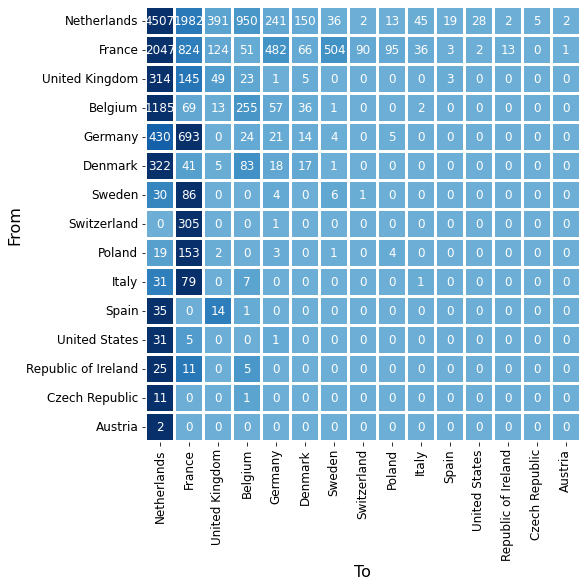

In [ ]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(12,8))

drawHeatmapMatrix(CC, labels=CC, format='.0f', xlabels = lookup.keys(), ylabels = lookup.keys(),
                  contrast = 0.0, normalize = 'rows')

plt.ylabel('From', fontsize=16)
plt.xlabel('To', fontsize=16)

plt.show();

## Timeline of Places

In [ ]:
N = 10
subheaders = ['label','#letters']

df['bin'] = pd.cut(df['start_year'], range(1400,1901,25))
df['bin'] = df.apply(lambda x: getIntervalRange(x.bin), axis=1)

XY = defaultdict(lambda: Counter())

for (label, bin), val in df.groupby(['from','bin']).size().iteritems():
  if val>0:
    XY[bin][label] += val

X = sorted(XY.keys())

header = [[k for k,_ in product(X, subheaders)],
          [k for _,k in product(X, subheaders)]
          ]
df2 = pd.DataFrame(columns = header)  

for bin, cnt in XY.items():
  arr = (cnt.most_common(N)+[('-','-')]*10)[:10]
  if len(arr)<N:
    arr = (arr+[('-','-')]*N)[:N]
  
  df2[(bin, subheaders[0])] = [k for k,_ in arr]
  df2[(bin, subheaders[1])] = [k for _,k in arr]

df2.index += 1
display(df2)

1575-1600                   1600-1625  ... 1675-1700 1700-1725         
        label #letters              label  ...  #letters     label #letters
1      Leiden        4          The Hague  ...       461     Delft      114
2   The Hague        4             London  ...       414    London        6
3       Delft        3              Paris  ...       123         -        -
4   Dragsholm        2          Rotterdam  ...        95         -        -
5      Leuven        1         Middelburg  ...        84         -        -
6       Paris        1             Leiden  ...        74         -        -
7           -        -            Lambeth  ...        47         -        -
8           -        -  Loevestein Castle  ...        30         -        -
9           -        -          Amsterdam  ...        19         -        -
10          -        -            Antwerp  ...        18         -        -

[10 rows x 12 columns]

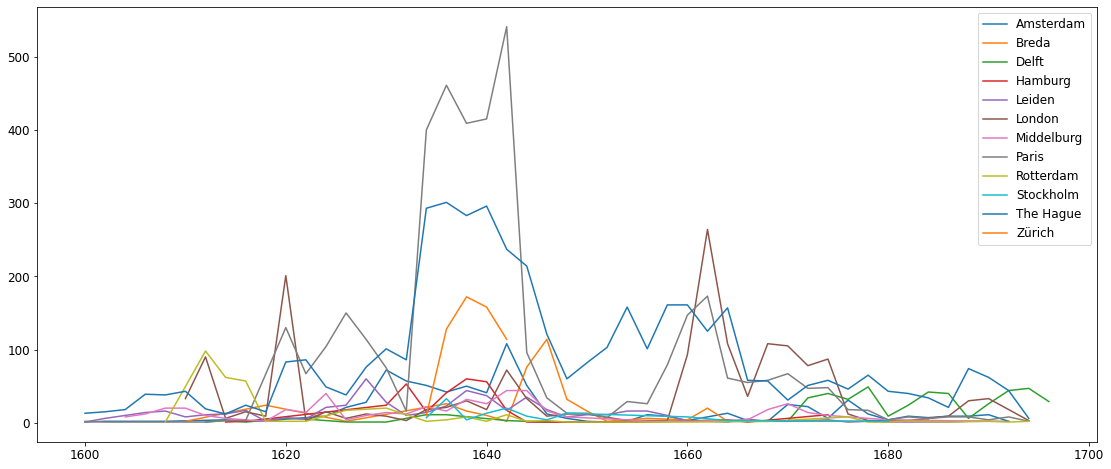

In [ ]:
N = 10

df['bin'] = pd.cut(df['start_year'], range(1600,1700,2))
df['bin'] = df.apply(lambda x: getIntervalStart(x.bin), axis=1)

XY = defaultdict(lambda: Counter())

for (label, year), val in df.groupby(['from','bin']).size().iteritems():
  if val>0 and label in lookup_places:
    XY[label][year] += val

fig = plt.figure(figsize=[19.0, 8.0])
ax = fig.add_subplot()
    
for label, cnt in XY.items():
  X = sorted(cnt.keys())
  Y = [cnt[x] for x in X]
  ax.plot(X,Y, label=label)

ax.legend()
plt.show()


## Places on a timeline during 17th century

In [ ]:
N = 10
subheaders = ['label','#letters']

df['bin'] = pd.cut(df['start_year'], range(1600,1701,10))
df['bin'] = df.apply(lambda x: getIntervalRange(x.bin), axis=1)

XY = defaultdict(lambda: Counter())

for (label, bin), val in df.groupby(['from','bin']).size().iteritems():
  if val>0:
    XY[bin][label] += val

X = sorted(XY.keys())

header = [[k for k,_ in product(X, subheaders)],
          [k for _,k in product(X, subheaders)]
          ]

df2 = pd.DataFrame(columns = header)

for bin, cnt in XY.items():
  arr = (cnt.most_common(N)+[('-','-')]*10)[:10]
  if len(arr)<N:
    arr = (arr+[('-','-')]*N)[:N]
  
  df2[(bin, subheaders[0])] = [k for k,_ in arr]
  df2[(bin, subheaders[1])] = [k for _,k in arr]

df2.index = list(range(1,N+1))
display(df2)

1600-1610                   1610-1620  ... 1680-1690  1690-1700         
         label #letters              label  ...  #letters      label #letters
1    The Hague      123          Rotterdam  ...       212      Delft      187
2       Leiden       47             London  ...       121  The Hague      112
3   Middelburg       40          The Hague  ...        45     London       57
4        Paris        6             Leiden  ...        42    Hanover       48
5    Amsterdam        5         Middelburg  ...        38      Paris       14
6   Heidelberg        5            Lambeth  ...        34  Amsterdam       13
7        Grave        2              Breda  ...        18   Hofwijck        8
8      Heusden        2  Loevestein Castle  ...        14  Rotterdam        5
9      Utrecht        2          Dordrecht  ...        12     Bremen        4
10      Arnhem        1             Oxford  ...         7      Veere        4

[10 rows x 20 columns]

In [ ]:
XY_places = defaultdict(lambda: defaultdict(OrderedDict))

for i, bin in enumerate(X):
  cnt = XY.get(bin, Counter())
  cnt = sorted([(k,v) for k,v in cnt.items() if k in lookup_places], key=lambda x:x[-1], reverse=True)
  for j, (label, _) in enumerate(cnt, start=1):
    if label in lookup_places:
      XY_places[label][i] = j

## rank chart of places, 17 century

In [ ]:
N = 12
clors = ['k', 'r', 'g', 'b',
         'k--', 'r--', 'g--', 'b--',
         'k:', 'r:', 'g:', 'b:',
         'k:', 'r:', 'g:', 'b:']         
widths = [2,2,2,2, 2,2,2,2, 4,4,4,4, 3,3,3,3]

ymax = 13
ys = [1]+list(range(5,ymax,5))

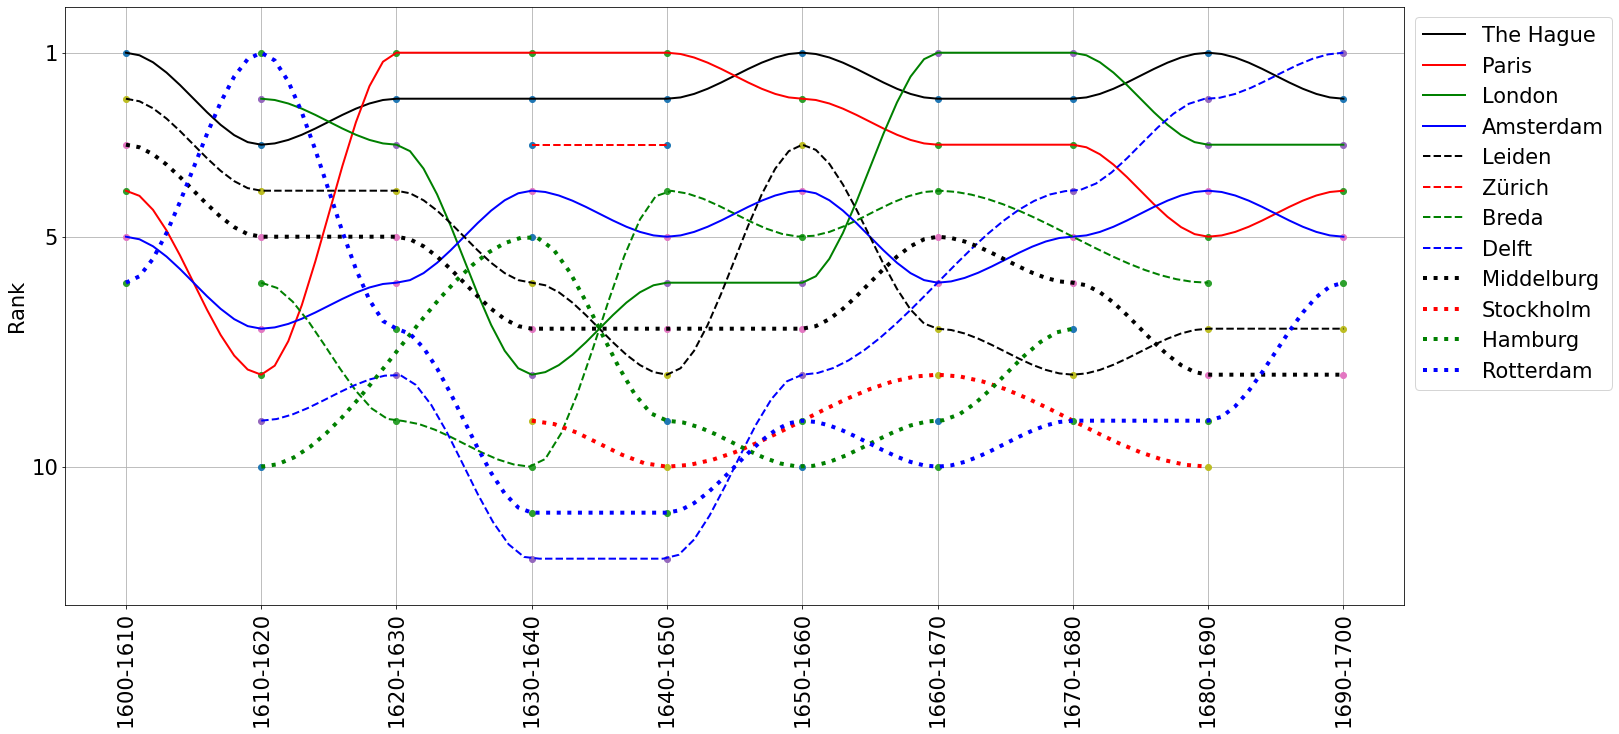

In [ ]:
plt.rcParams.update({'font.size': 21})
fig = plt.figure(figsize=[24.0, 11.0])
ax = fig.add_subplot()

for i, label in enumerate(lookup_places.keys()):
  if i>=N: 
    break
  arr = XY_places.get(label)
  if arr:
    X = sorted(arr.keys())
    Y = np.array([arr[x] for x in X])
    
    ax.plot(X,Y, 'o', clors[i], label='_nolegend_', linewidth = 8)
    ax.plot(*getSpline(np.array(X),Y), clors[i], linewidth=widths[i])
  
    
plt.ylim(0,ymax)
plt.ylabel('Rank')
plt.gca().invert_yaxis()

ax.grid()
ax.legend(lookup_places.keys(), loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.yticks(ys, labels = ys)
plt.xticks(range(len(XY)), labels = sorted(XY.keys()), rotation=90)

plt.savefig("top_places_{}.png".format(N), dpi=None, transparent=False, bbox_inches='tight')
plt.show()

## Average year with standard deviation for the places

In [ ]:
lookup_places.keys()
df2 = df[df['from'].isin(lookup_places.keys())]
df3 = df2.groupby('from').mean()
df3['std'] = df2.groupby('from').std()
display(df3)

,start_year,std
from,,
Amsterdam,1646.601828,18.349389
Breda,1646.098901,10.968580
Delft,1684.822047,19.796874
Hamburg,1639.498258,9.210770
Leiden,1635.632353,16.916133
London,1653.849541,22.902205
Middelburg,1639.331984,19.816069
Paris,1643.734232,14.214597
Rotterdam,1624.342857,18.080585
